# OpenCL challenge - Edge detection with image correlation

## Introduction

The development of Convolutional neural networks has brought about a significant advance in machine learning capabilities in computer vision. Training and inference in Convolutional Neural networks rely on the application of many filters to an image via 2D discrete convolution. If $I$ is a 2D image and $K$ is a filter, then a 2D discrete convolution is 

$$V(i,j)=(I*K)(i,j)=\sum_{u}\sum_v I(i-u,j-v)K(u,v)$$

In practice, convolutional neural networks are not affected if the filter is flipped, so a conceptually-simpler cross-correlation is used instead. 

$$C(i,j)=(I\star K)(i,j)=\sum_{u}\sum_v I(i+u,j+v)K(u,v)$$


Source: The book **Deep Learning** by Goodfellow, Bengio, and Courville, available at this link [here](https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/ref=sr_1_3?ie=UTF8&qid=1533006310&sr=8-3&keywords=deep+learning).

The algorithm for implementing a cross-correlation can be visualised as follows. The image is padded with zeros and the filter is applied to every pixel in the filtered image, using the value in the pixel and its neighbours as the input. Points in the image are multiplied by corresponding points in the filter and the result is summed to produce a value at that pixel. By applying the filter across the image one can make a filtered image ready for further processing in the convolutional neural network.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="../images/correlation.svg" width="65%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: The cross-correlation algorithm with an edge detection filter. The fillter (in orange) is cross-correlated with the image. The blue region of the image represents the region over which the correlation is valid. The white region is the padding. </figcaption>
</figure>

## The story

In this hypothetical exercise the filter above is an edge detection filter. Your colleagues are keen on applying this filter to a stack of images as the first stage in a machine vision experiment. Unfortunately their Python solution isn't fast enough for the onboard electronics in use. As you are the OpenCL expert in the group, your colleagues are looking to you for a faster way to compute a cross correlation over a stack of images. 

## Task 0: Calculate the arithmetic density.

For every pixel that is computed there are 18 fetches and 1 store. There are 9 multiplies and 9 adds for a total of 18 Flops per pixel. If every pixel uses four bytes to store its value what is the arithmetic density (Flops/Byte ratio) for this algorithm? Is it likely to be memory bandwidth or compute limited?

## Construct some example input data

On a recent hike to the Porongorups National Park you took this image and can use it to generate a trial stack of images.

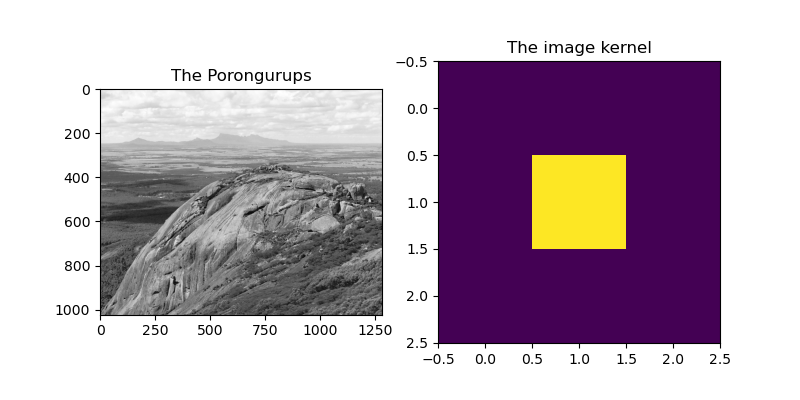

In [1]:
import numpy as np
import skimage
from ipywidgets import widgets
from matplotlib import pyplot as plt
from skimage import color, io
import os
import sys
sys.path.insert(0, os.path.abspath("../include"))
import py_helper
from scipy.signal import correlate

def fetch_image(large_image, offset0, offset1, N0, N1):
    return large_image[offset0: offset0+N0, offset1: offset1+N1]

# Choose this for plot display through a notebook
%matplotlib widget

# Get array sizes directly from mat_size.hpp
defines=py_helper.load_defines("mat_size.hpp")

# define a standard data type
float_type = np.float32

# Read in the image
im_col = io.imread(os.path.join("..","images","Porongorups.JPG"))
large_image = color.rgb2gray(im_col).astype(float_type)

# Starting coordinates for the image read
start0=747
start1=1175
sample_image = fetch_image(large_image, start0, start1, defines["N0"], defines["N1"])

# Plot the image
[fig, ax] = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(sample_image, cmap=plt.get_cmap("Greys_r"))
ax[0].set_title("The Porongurups")

# Get the filter
filtr = np.zeros((3,3), dtype=float_type) - 1.0
filtr[1,1] = 8.0

# These are the paddings
pad0_l = defines["L0"]
pad0_r = defines["R0"]
pad1_l = defines["L1"]
pad1_r = defines["R1"]

# Plot the image kernel
#ax[1].imshow(filtr, cmap=plt.get_cmap("Greys_r"))
ax[1].imshow(filtr)
ax[1].set_title("The image kernel")
plt.show()

### Write the stack of images to file

In [2]:
# Number of images to write
nimages = defines["NIMAGES"]

# Make a stack of images to write, choose an ar
images_in = np.zeros((nimages, *sample_image.shape), dtype=sample_image.dtype)
for n in range(0, nimages):
    images_in[n,:,:] = fetch_image(large_image, start0, start1+n, defines["N0"], defines["N1"])
    
# Write out the images to file
images_in.tofile("images_in.dat")

# Write out the filter to file
filtr.tofile("image_kernel.dat")

# Plot the input images
py_helper.plot_slices(images_in)

interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…

### The existing Python cross-correlation solution

The following algorithms are the best solution your colleagues could come up with... They generate a stack of images **proof_images** that you can use to check with your solution.

In [8]:
import time
import numpy as np
from scipy.signal import correlate

def xcor2d_slicing(image_in, image_out, filtr, pad0_l, pad0_r, pad1_l, pad1_r):
    """2D cross correlation that uses the full Numpy array."""
    reduced_shape = (image_in.shape[0] - pad0_l -pad0_r, image_in.shape[1] - pad1_l - pad1_r)
    selection = np.s_[pad0_l : pad0_l+reduced_shape[0], pad1_l : pad1_l + reduced_shape[1]]
    result = np.zeros(reduced_shape, dtype=image_in.dtype)

    # Loop over the filter which is of small size
    for x in range(-pad0_l, pad0_r+1):
        for y in range(-pad1_l, pad1_r+1):
            temp = image_in[
                x + pad0_l : x + pad0_l + reduced_shape[0], y + pad1_l : y + pad1_l + reduced_shape[1]
            ]
            result = result + filtr[x+pad0_l, y+pad1_l] * temp

    image_out[selection] = result
            
def xcor2d_scipy(image_in, image_out, filtr):
    """Use A canned Scipy function to do image correlation."""
    shape_corr = tuple(np.int32(np.array(image_in.shape) - np.array(filtr.shape) + 1))
    image_out[0:shape_corr[0], 0:shape_corr[1]] = correlate(image_in, filtr, mode="valid")

# Make up the proof images
proof_images = np.zeros_like(images_in)
    
# Time how quick Python takes to run
t1 = time.perf_counter()

image_out = np.zeros_like(sample_image)
for n in range(0, nimages):
    image_in = images_in[n, :, :]
    # Uncomment one of these to choose Python slicing or Scipy correlation
    xcor2d_slicing(image_in, image_out, filtr, pad0_l, pad0_r, pad1_l, pad1_r)
    #xcor2d_scipy(image_in, image_out, filtr)
    proof_images[n,...] = image_out[:]
    
t2 = time.perf_counter()
print(f"Python image processing rate is {nimages/(t2-t1):.2f} images/s")

py_helper.plot_slices(proof_images)

# Using Scipy took me about 5.30 images/s

Python image processing rate is 106.85 images/s


interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…

## OpenCL solution

While thinking about this problem you came across a brilliant idea! The correlation process can be farmed out to multiple compute devices, as shown below:

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="../images/farming_out.svg" width="65%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: Farming out the cross-correlations among available devices. </figcaption>
</figure>

A fellow colleague has already created a program to load the images and iterate over them with a dynamic pool of OpenMP threads. Each OpenMP thread will correspond to an available OpenCL compute device. The pool assigns the next image to a thread (compute device) as it finishes work. Your tasks are to add in the necessary bits of OpenCL code to upload and download memory to the compute devices and complete the correlations.

### Source code

The sources for this project are: 

* Cross-correlation program (to edit) [xcorr.cpp](xcorr.cpp). 
* Helper headers (for reference) <a href="../include/cl_helper.hpp">cl_helper.hpp</a> 
* kernel source (to edit) [kernels.cl](kernels.cl)

### Tasks

You can choose which tasks you'd like to try, maybe just one task or all of them. You might want to focus on a particular aspect, such as:

* Resource discovery
* Kernel creation
* IO optimisation
* Kernel optimisation
* Program optimisation

Here are the tasks required to make the code operational.

#### **Task 1** - Code to create the OpenCL buffers for each thread
For every device at index **n**, use the function [clCreateBuffer](https://registry.khronos.org/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html) to create buffers for **buffer_srces[n]**, **buffer_dests[n]** and the image kernel buffer **buffer_kerns[n]**. You have **contexts[n]** available as the context associated with each device. You might want to consider using [clEnqueueFillBuffer](https://registry.khronos.org/OpenCL/sdk/3.0/docs/man/html/clEnqueueFillBuffer.html) to zero out the contents of the **buffer_dests[n]** array, as the edge may not be written to. 
    
#### **Task 2** - Code to set kernel arguments for each thread
For every device at index **n** set all arguments to **kernels[n]**. Have a look at the **xcorr** kernel preamble in [kernels.cl](kernels.cl) to make sure you have the right data type. 

#### **Task 3** - Code to upload memory to the compute device buffer

Within the OpenMP loop over the images is a place to upload memory, enqueue the correlation kernel, and download memory. If **tid** is the thread id, you can use the OpenCL function [clEnqueueWriteBuffer](https://registry.khronos.org/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) to write **nbytes_image** of memory from **images_in** at position **offset** to the OpenCL buffer **buffer_srces[tid]**. You have **command_queues[tid]** available to perform the copy and can use **blocking** transfers.

#### **Task 4** - A kernel to perform the cross-correlation for each pixel

This task is probably the most challenging. Have a look at the kernel source [kernels.cl](kernels.cl). The variables **gid0** and **gid1** cover **at least** the domain of the source buffer **src**. Consider the source array as being already padded, so make sure you don't read or write outside either the **src** image or the image kernel **kern**. The source image is of size **(len0_src, len1_src)**, and the variables **pad0_l, pad0_r, pad1_l, pad1_r** represent the left and right padding for dimensions 0 and 1.

If you get stuck at this point you can take a peek at the answer [kernels_answers.cl](kernels_answers.cl) or just load the answers kernel by swapping the comments on these two lines.

```C++
    // Read kernel sources 
    //const char* filename = "kernels_answers.cl"
    const char* filename = "kernels.cl";
```

#### **Task 5** - Code to enqueue the kernel

Once the kernel is written, you can enqueue **kernels[tid]** using **command_queues[tid]** and the OpenCL function [clEnqueueNDRangeKernel](https://registry.khronos.org/OpenCL/sdk/3.0/docs/man/html/clEnqueueNDRangeKernel.html). 

#### **Task 6** - Code to download memory from the compute device buffer

Finally, within the OpenMP loop you need to be able to read memory of size **nbytes_image** from **buffer_dests[tid]** to **images_out** at position **offset**. Use the OpenCL function [clEnqueueReadBuffer](https://registry.khronos.org/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) and use **blocking** transfers.

#### **Task 7** - Compile and debug

It is always a good idea to check your memory transfers first, to make sure that output from the kernel is making it into the right place in **images_out**. The program **oclgrind** is helpful in diagnosing faults in the use of OpenCL functions and memory errors in kernels. Once you are satisfied memory is being transferred correctly then proceed to finish the kernel. In the cells below is functionality to compile **xcorr.exe** and to run and check output.

#### If you get stuck

The program [xcorr.cpp](xcorr.cpp) has clearly delineated sections where you can insert code for each task. If you get stuck, or want to skip a task, you can uncomment a line that includes the answer i.e. 

```C++
        // Uncomment this to include the solution
        //#include "task1_answer.hpp"
```

As always, the full solution is available at the sources below. If you need inspiration by all means take a peek at the solution.

* Cross-correlation program (for reference) [xcorr_answers.cpp](xcorr_answers.cpp). 
* kernel source (for reference) [kernels_answers.cl](kernels_answers.cl)

### Inspect devices

In [9]:
!clinfo -l

Platform #0: Intel(R) FPGA Emulation Platform for OpenCL(TM)
 `-- Device #0: Intel(R) FPGA Emulation Device
Platform #1: Intel(R) OpenCL
 `-- Device #0: AMD Ryzen 7 6800H with Radeon Graphics         
Platform #2: AMD Accelerated Parallel Processing
 `-- Device #0: gfx1035
Platform #3: NVIDIA CUDA
 `-- Device #0: NVIDIA GeForce RTX 3060 Laptop GPU


### Compile and run the program

In it's current configuration the code doesn't produce any results.

In [10]:
!make; ./xcorr.exe

make: Nothing to be done for 'all'.
	               name: Intel(R) FPGA Emulation Device 
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (67108864,67108864,67108864)
	     max work-items: 67108864
	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
	               name: gfx1035 
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Processing iteration 1 of 1
Device 0 processed 9 of 100 images (9.00%)
Device 1 processed 39 of 100 images (39.00%)
Device 2 processed 34 of 100 images (34.00%)
Device 3 processed 18 of 100 images (18.00%)
Overall processing rate 4

### Read and check the results

In [11]:
def check_solution(images, proof_images, cmap="Greys_r"):
    
    # Get the dimensions
    nslices, N0, N1 = images.shape
    
    # Animate the result
    fig, ax = plt.subplots(1,2, figsize=(10,6), sharex=True, sharey=True)
    extent=[ -0.5, N1-0.5, -0.5, N0-0.5]
    
    img0 = ax[0].imshow(
        images[0,...], 
        extent=extent, 
        vmin=np.min(proof_images), 
        vmax=np.max(proof_images),
        cmap=plt.get_cmap(cmap)
    )
    
    img1 = ax[1].imshow(
        proof_images[0,...], 
        extent=extent, 
        vmin=np.min(proof_images), 
        vmax=np.max(proof_images),
        cmap=plt.get_cmap(cmap)
    )

    ax[0].set_xlabel("Dimension 1")
    ax[0].set_ylabel("Dimension 0")
    ax[0].set_title("Images")

    ax[1].set_xlabel("Dimension 1")
    ax[1].set_title("Proof images")
    
    def update(n=0):
        img0.set_data(images[n,...])
        img1.set_data(proof_images[n,...])
        plt.show()
    
    # Run the interaction
    result = widgets.interact(
        update,
        n=(0, nslices-1, 1)
    )

# Read images from file
images = np.fromfile("images_out.dat", dtype=float_type).reshape(defines["NIMAGES"], defines["N0"], defines["N1"])
check_solution(images, proof_images)

interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…

### Success?

If you were able to see edges in both **Images** and **Proof images** and they look the same then congratulations! You have successfully completed the task and your project can progress! Otherwise by all means take a peek at the answers.

## The answer

### CPU only

In [12]:
!./xcorr_answers.exe -cpu

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Processing iteration 1 of 1
Device 0 processed 100 of 100 images (100.00%)
Overall processing rate 712.88 images/s


### GPUs only

In [13]:
!./xcorr_answers.exe -gpu

	               name: gfx1035 
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Processing iteration 1 of 1
Device 0 processed 57 of 100 images (57.00%)
Device 1 processed 43 of 100 images (43.00%)
Overall processing rate 427.60 images/s


### CPU's and GPU's

In [16]:
!./xcorr_answers.exe

	               name: Intel(R) FPGA Emulation Device 
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (67108864,67108864,67108864)
	     max work-items: 67108864
	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 32878 MB
	    max buffer size: 16439 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
	               name: gfx1035 
	 global memory size: 536 MB
	    max buffer size: 456 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Processing iteration 1 of 1
Device 0 processed 7 of 100 images (7.00%)
Device 1 processed 52 of 100 images (52.00%)
Device 2 processed 27 of 100 images (27.00%)
Device 3 processed 14 of 100 images (14.00%)
Overall processing rate 555.56 images/s


In [17]:
# Read images from file
images = np.fromfile("images_out.dat", dtype=float_type).reshape(defines["NIMAGES"], defines["N0"], defines["N1"])
check_solution(images, proof_images)

interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…